# Goal: 93.10%

In [1]:
!wget -q https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/EQodPFqgjvtLp-ux1_vmqf4Bz5Q1pn3Gk1VT0CNpzN1EwA?download=1 -O "Project 2 - data.zip"
!unzip -q "Project 2 - data.zip"

In [2]:
!pip install --upgrade gensim

     |████████████████████████████████| 23.9MB 128kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
import networkx as nx
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Pipeline

### Data Loader

We need to load networks into memory. Usually networks are organized as pairs of nodes. And sometimes different edges have different weights. Hence, we use networkx.DiGraph to store such structure information and attributes.

In [4]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    
    return edges

def load_test_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append((row["src"], row["dst"]))
    edges = sorted(edges)
    
    return edges

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges)
    print(N, len(true_edges))
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)]
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)
    
    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

### Random Walk Generator

Random walk generators or random walkers yield random walks that contain both local and higher-order neighborhood information. However, naive non-uniform sampling is very slow, which requires O(n) time complexity. Here alias sampling can reduce the time complexity to O(1) with O(n) space. If you are interested, please see the following blog.

In [5]:
def alias_setup(probs):
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = list()
    larger = list()
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def get_alias_node(graph, node):
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]["weight"])
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs
        
    return alias_setup(normalized_probs)
    
def get_alias_edge(graph, src, dst, p=1, q=1):
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src: # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/p)
        elif graph.has_edge(dst_nbr, src): # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"])
        else: # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges

The difference between DeepWalk and node2vec is how to generate random walks. The former only consider the first-order information while the latter also involves the second-order information.

In [6]:
def alias_draw(J, q):
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


# helper function to generate the long random walk as desired
def fallback(walk, fetch_last_num=1):
    if len(walk) > fetch_last_num:
        walk.pop()
        fetched = []
        for i in range(fetch_last_num):
            fetched.append(walk[-1-i])
        return walk, fetched
    else:
        return [], [None for _ in range(fetch_last_num)]

def generate_first_order_random_walk(graph, alias_nodes, 
                                     walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the first order information.
    max_trials: set the max trials to be one for standard random walk. Larger max_trails will make the generated biased.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    cur = start_node
    num_tried = 0
    
    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0: # if we can sample next nodes
            # sample the next node based on alias_nodes
            cur = cur_nbrs[alias_draw(*alias_nodes[cur])]
            walk.append(cur)
        else: # if we can't do that
            num_tried += 1
            if num_tried >= max_trails:
                break

            walk, fetched = fallback(walk, fetch_last_num=1)
            cur = fetched[0]
            if len(walk) == 0: # if falls back to the empty walk
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
    ########## end ##########

    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk
    
def generate_second_order_random_walk(graph, alias_nodes, alias_edges, 
                                      walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    
    prev = None
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])]
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            num_tried += 1
            if num_tried >= max_trails:
                break
            walk, (cur, prev) = fallback(walk, fetch_last_num=2)
            if len(walk) == 0:
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
                prev = None
    ########## end ##########
    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

### Network Embedding Algorithms

In [7]:
def build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10):
    """
    build a deepwalk model
    """
    print("building a DeepWalk model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))
        
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    # model = Word2Vec(walks, size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    print("training time: %.4f" % (time.time()-st))
    
    return model

def build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10):
    """
    build a node2vec model
    """
    print("building a node2vec model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))
            
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0    
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    print("training time: %.4f" % (time.time()-st))
    
    return model

### Scorer

In [8]:
def get_cosine_sim(model, u, v):
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv[u]
        v = model.wv[v]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return 0.5

def get_auc_score(model, true_edges, false_edges):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)
    
    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    
    return roc_auc_score(y_true, y_score)

def write_pred(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)
    
    



def write_valid_ans(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

### Try them over a Real-life Network

Firstly, we need to load edges into memory and use the networkx.DiGraph structure to store the graph.

In [9]:
train_file = "data/train.csv"
valid_file = "data/valid.csv"
test_file = "data/test.csv"

np.random.seed(0)
train_edges = load_data(train_file)
graph = construct_graph_from_edges(train_edges)
valid_edges = load_data(valid_file)
false_edges = generate_false_edges(train_edges+valid_edges, 40000-len(valid_edges))
test_edges = load_test_data(test_file)

number of nodes: 8328
number of edges: 100000
8474 119268


After that, we can use preprocess transition probabilities with the help of alias sampling.

In [10]:
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=1, q=1)

We can use random walk generators to generate random walks.

Let's try to generate a first-order random walk and a second-order random walk.

In [11]:
generate_first_order_random_walk(graph, alias_nodes=alias_nodes,
                                 start_node="N6ZTMIue-2b30CJv2tyPGg", walk_length=10)

['N6ZTMIue-2b30CJv2tyPGg',
 'rEVrHXlCNGQNOfWDKxOnTQ',
 'N6ZTMIue-2b30CJv2tyPGg',
 'u0aFzHN2GzAq2czVKcDmqg',
 'N6ZTMIue-2b30CJv2tyPGg',
 'cvAPwZRWaDxSUudy8CR3Rw',
 '9E35LB29RXJixo0563Iwew',
 'V74paj6Zok4DvGnciFEZMg',
 'hiEQhuyMOSKCvVqmHrpvhg',
 'V74paj6Zok4DvGnciFEZMg']

In [12]:
generate_second_order_random_walk(graph, alias_nodes=alias_nodes, alias_edges=alias_edges,
                                  start_node="N6ZTMIue-2b30CJv2tyPGg", walk_length=10)

['N6ZTMIue-2b30CJv2tyPGg',
 'rEVrHXlCNGQNOfWDKxOnTQ',
 'mTRDblbRHCLKv1ZDxo9zcw',
 'KxGeqg5ccByhaZfQRI4Nnw',
 's79vzEzqavL_29pmraXZBA',
 '-d78vV86WnU2uWac1fEntA',
 '7C4B2Skmh4X9f8xJDo9O4w',
 'MQwSyZ2MZ6N7rtAmphZCow',
 'MPGqUhAsmVEHq9k9X6VZKw',
 'DXh8yxwZCg5Ckj5kmDvKXw']

And we can build a DeepWalk model and a node2vec model. Here we set p=q=0.5 so that the walker will not go very far away from the start node.

In [13]:
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10)

building a DeepWalk model...	number of walks: 83280	average walk length: 9.8980	training time: 29.6275


In [14]:
model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10)

building a node2vec model...	number of walks: 83280	average walk length: 9.9910	training time: 32.3465


Let's see the node embeddings of three nodes, and cosine similarities of two edges.

In [15]:
print("node embedding (\"N6ZTMIue-2b30CJv2tyPGg\"):",
      model.wv["N6ZTMIue-2b30CJv2tyPGg"])
print("node embedding (\"N7E-CfqdME28dakWdEKNvw\"):",
      model.wv["N7E-CfqdME28dakWdEKNvw"])
print("node embedding (\"MmlJSLDg-IFaeXb5wdJbgg\"):",
      model.wv.vectors[model.wv.index_to_key.index("MmlJSLDg-IFaeXb5wdJbgg")])
print("true edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"N7E-CfqdME28dakWdEKNvw\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"))
print("false edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"MmlJSLDg-IFaeXb5wdJbgg\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"))

node embedding ("N6ZTMIue-2b30CJv2tyPGg"): [ 0.11196358 -0.8177345   1.5127106   1.1980542  -1.2538775   0.32229194
  0.9725047   1.2944263  -0.6359866  -0.4116282 ]
node embedding ("N7E-CfqdME28dakWdEKNvw"): [ 0.67480683 -0.46806693  1.2138338   0.67284125 -0.8479994   0.17263702
  1.6701664   0.90647745  0.09616276 -0.94704735]
node embedding ("MmlJSLDg-IFaeXb5wdJbgg"): [ 0.4183885   0.13997929 -1.3920959   0.28452313  1.200367    1.305434
  2.4075956   1.2818934  -0.8343017  -2.3281662 ]
true edge ("N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"): 0.8599178
false edge ("N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"): 0.1942241


# Link Prediction

We can train the model with different parameters and test the model on the validation set. Please show your parameter search process and analysis in your code, and visualization tools (Heatmap, etc.) are recommended to make your analysis clear.

In [16]:
np.random.seed(0)

node_dim = 10
num_walks = 10
walk_length = 10

deepwalk_auc_scores = dict()

print("node dim: %d,\tnum_walks: %d,\twalk_length: %d" % (node_dim, num_walks, walk_length), end="\t")
model = build_deepwalk(graph, alias_nodes, 
                       node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
deepwalk_auc_scores[(node_dim, num_walks, walk_length)] = get_auc_score(model, valid_edges, false_edges)
print("auc: %.4f" % (deepwalk_auc_scores[(node_dim, num_walks, walk_length)]))

node dim: 10,	num_walks: 10,	walk_length: 10	building a DeepWalk model...	number of walks: 83280	average walk length: 9.8980	training time: 29.5680
auc: 0.9275


In [17]:
np.random.seed(0)

node_dim = 10
num_walks = 10
walk_length = 10
p = 0.5
q = 0.5

node2vec_auc_scores = dict()
print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
    node_dim, num_walks, walk_length, p, q), end="\t")
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
model = build_node2vec(graph, alias_nodes, alias_edges, 
                       node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] = get_auc_score(model, valid_edges, false_edges)
print("auc: %.4f" % (node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)]))

node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.50	building a node2vec model...	number of walks: 83280	average walk length: 9.9918	training time: 32.5094
auc: 0.9271


# Deep Walk Hyperparameter Optimization

## num_walks, walk_length

In [38]:
np.random.seed(0)

node_dim = 10
num_walks = 10
walk_length = 10

deepwalk_auc_scores = dict()

In [39]:
walk_length_list = [10, 20, 40]
num_walks_list = [5, 10, 20, 40]

for walk_length_i in walk_length_list:
    for num_walks_i in num_walks_list:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d" % (node_dim, num_walks_i, walk_length_i), end="\t")
        model = build_deepwalk(graph, alias_nodes, 
                              node_dim=node_dim, num_walks=num_walks_i, walk_length=walk_length_i)
        deepwalk_auc_scores[(node_dim, num_walks_i, walk_length_i)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (deepwalk_auc_scores[(node_dim, num_walks_i, walk_length_i)]))

node dim: 10,	num_walks: 5,	walk_length: 10	building a DeepWalk model...	number of walks: 41640	average walk length: 9.8976	training time: 15.1966
auc: 0.9116
node dim: 10,	num_walks: 10,	walk_length: 10	building a DeepWalk model...	number of walks: 83280	average walk length: 9.8980	training time: 29.4260
auc: 0.9275
node dim: 10,	num_walks: 20,	walk_length: 10	building a DeepWalk model...	number of walks: 166560	average walk length: 9.8981	training time: 58.5204
auc: 0.9329
node dim: 10,	num_walks: 40,	walk_length: 10	building a DeepWalk model...	number of walks: 333120	average walk length: 9.8984	training time: 115.9550
auc: 0.9319
node dim: 10,	num_walks: 5,	walk_length: 20	building a DeepWalk model...	number of walks: 41640	average walk length: 19.7535	training time: 26.7268
auc: 0.9269
node dim: 10,	num_walks: 10,	walk_length: 20	building a DeepWalk model...	number of walks: 83280	average walk length: 19.7559	training time: 52.4619
auc: 0.9323
node dim: 10,	num_walks: 20,	walk_len

In [41]:
deepwalk_auc_scores

{(10, 5, 10): 0.9116397186014497,
 (10, 5, 20): 0.9269012398248198,
 (10, 5, 40): 0.9298399376368609,
 (10, 10, 10): 0.9275003085633391,
 (10, 10, 20): 0.9322516532746605,
 (10, 10, 40): 0.9303785553976686,
 (10, 20, 10): 0.932889894487059,
 (10, 20, 20): 0.9319410709810434,
 (10, 20, 40): 0.9284349280422082,
 (10, 40, 10): 0.9319140072275216,
 (10, 40, 20): 0.930017394100441,
 (10, 40, 40): 0.9264914108342972}

Text(0, 0.5, 'num_walks')

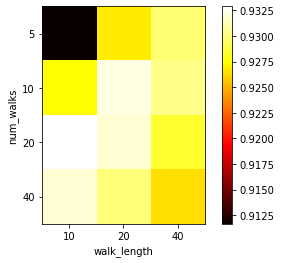

In [42]:
# plt.figure(figsize=(6, 4))
a = np.array([[deepwalk_auc_scores[(node_dim, num_walks, walk_length)] for walk_length in [10, 20, 40]] for num_walks in [5, 10, 20, 40]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels=[10, 20, 40])
plt.xlabel("walk_length")
plt.yticks(ticks=[0,1,2,3], labels=[5, 10, 20, 40])
plt.ylabel("num_walks")

## node_dim

In [43]:
np.random.seed(0)

node_dim = 10
num_walks = 10
walk_length = 10

deepwalk_auc_scores = dict()

In [44]:
node_dim_list = [5, 10, 20, 30, 40]

for node_dim_i in node_dim_list:
    print("node dim: %d,\tnum_walks: %d,\twalk_length: %d" % (node_dim_i, num_walks, walk_length), end="\t")
    model = build_deepwalk(graph, alias_nodes, 
                          node_dim=node_dim_i, num_walks=num_walks, walk_length=walk_length)
    deepwalk_auc_scores[(node_dim_i, num_walks, walk_length)] = get_auc_score(model, valid_edges, false_edges)
    print("auc: %.4f" % (deepwalk_auc_scores[(node_dim_i, num_walks, walk_length)]))

node dim: 5,	num_walks: 10,	walk_length: 10	building a DeepWalk model...	number of walks: 83280	average walk length: 9.8980	training time: 27.7665
auc: 0.9077
node dim: 10,	num_walks: 10,	walk_length: 10	building a DeepWalk model...	number of walks: 83280	average walk length: 9.8980	training time: 29.6108
auc: 0.9275
node dim: 20,	num_walks: 10,	walk_length: 10	building a DeepWalk model...	number of walks: 83280	average walk length: 9.8980	training time: 33.7185
auc: 0.9094
node dim: 30,	num_walks: 10,	walk_length: 10	building a DeepWalk model...	number of walks: 83280	average walk length: 9.8980	training time: 38.2472
auc: 0.8834
node dim: 40,	num_walks: 10,	walk_length: 10	building a DeepWalk model...	number of walks: 83280	average walk length: 9.8980	training time: 31.3954
auc: 0.8541


Text(0, 0.5, ' ')

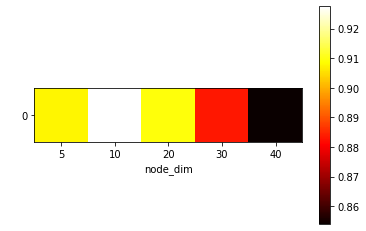

In [45]:
a = np.array([[deepwalk_auc_scores[(node_dim, num_walks, walk_length)] for node_dim in [5, 10, 20, 30, 40]]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2, 3, 4], labels=[5, 10, 20, 30, 40])
plt.xlabel("node_dim")
plt.yticks(ticks=[0], labels=[0])
plt.ylabel(" ")

# Node2Vec Hyperparameter Optimization

## p, q

In [22]:
np.random.seed(0)

node_dim = 10
num_walks = 10
walk_length = 10
p = 0.5
q = 0.5

node2vec_auc_scores = dict()

In [23]:
p_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for pi in p_list:
    qi = 1 - pi
    print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
        node_dim, num_walks, walk_length, pi, qi), end="\t")
    alias_nodes, alias_edges = preprocess_transition_probs(graph, p=pi, q=qi)
    model = build_node2vec(graph, alias_nodes, alias_edges, 
                          node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
    node2vec_auc_scores[(node_dim, num_walks, walk_length, pi, qi)] = get_auc_score(model, valid_edges, false_edges)
    print("auc: %.4f" % (node2vec_auc_scores[(node_dim, num_walks, walk_length, pi, qi)]))

node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.20,	q: 0.80	building a node2vec model...	number of walks: 83280	average walk length: 9.9921	training time: 32.2831
auc: 0.9273
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.30,	q: 0.70	building a node2vec model...	number of walks: 83280	average walk length: 9.9915	training time: 32.2409
auc: 0.9289
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.40,	q: 0.60	building a node2vec model...	number of walks: 83280	average walk length: 9.9923	training time: 32.0455
auc: 0.9278
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.50	building a node2vec model...	number of walks: 83280	average walk length: 9.9918	training time: 32.3878
auc: 0.9270
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.60,	q: 0.40	building a node2vec model...	number of walks: 83280	average walk length: 9.9911	training time: 32.6981
auc: 0.9271
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.70,	q: 0.30	building a node2vec model...	number of walks: 8

In [24]:
node2vec_auc_scores

{(10, 10, 10, 0.2, 0.8): 0.9273059156623846,
 (10, 10, 10, 0.3, 0.7): 0.928910744176469,
 (10, 10, 10, 0.4, 0.6): 0.9278094188851618,
 (10, 10, 10, 0.5, 0.5): 0.9269972196455485,
 (10, 10, 10, 0.6, 0.4): 0.927142848474102,
 (10, 10, 10, 0.7, 0.30000000000000004): 0.9254302305696619,
 (10, 10, 10, 0.8, 0.19999999999999996): 0.9260495501854464,
 (10, 10, 10, 0.9, 0.09999999999999998): 0.9254678697395884}

Text(0, 0.5, 'q = 1 - p')

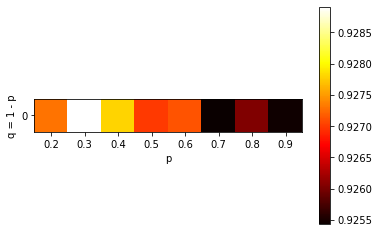

In [29]:
a = np.array([[node2vec_auc_scores[(node_dim, num_walks, walk_length, pi, 1-pi)] for pi in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2, 3, 4, 5, 6, 7], labels=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.xlabel("p")
plt.yticks(ticks=[0], labels=[0])
plt.ylabel("q = 1 - p")

## num_walks, walk_length

In [32]:
np.random.seed(0)

node_dim = 10
num_walks = 10
walk_length = 10
p = 0.5
q = 0.5

node2vec_auc_scores = dict()

In [33]:
walk_length_list = [10, 20, 40]
num_walks_list = [5, 10, 20, 40]

for walk_length_i in walk_length_list:
    for num_walks_i in num_walks_list:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
            node_dim, num_walks_i, walk_length_i, p, q), end="\t")
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
        model = build_node2vec(graph, alias_nodes, alias_edges, 
                              node_dim=node_dim, num_walks=num_walks_i, walk_length=walk_length_i)
        node2vec_auc_scores[(node_dim, num_walks_i, walk_length_i, p, q)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (node2vec_auc_scores[(node_dim, num_walks_i, walk_length_i, p, q)]))

node dim: 10,	num_walks: 5,	walk_length: 10,	p: 0.50,	q: 0.50	building a node2vec model...	number of walks: 41640	average walk length: 9.9919	training time: 16.4740
auc: 0.9144
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.50	building a node2vec model...	number of walks: 83280	average walk length: 9.9918	training time: 32.1429
auc: 0.9271
node dim: 10,	num_walks: 20,	walk_length: 10,	p: 0.50,	q: 0.50	building a node2vec model...	number of walks: 166560	average walk length: 9.9915	training time: 63.9802
auc: 0.9299
node dim: 10,	num_walks: 40,	walk_length: 10,	p: 0.50,	q: 0.50	building a node2vec model...	number of walks: 333120	average walk length: 9.9912	training time: 127.8222
auc: 0.9294
node dim: 10,	num_walks: 5,	walk_length: 20,	p: 0.50,	q: 0.50	building a node2vec model...	number of walks: 41640	average walk length: 19.9671	training time: 29.0397
auc: 0.9266
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.50,	q: 0.50	building a node2vec model...	number of walks:

Text(0, 0.5, 'num_walks')

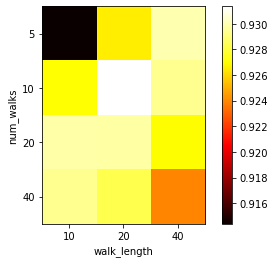

In [34]:
plt.figure(figsize=(6, 4))
a = np.array([[node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] for walk_length in [10, 20, 40]] for num_walks in [5, 10, 20, 40]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels=[10, 20, 40])
plt.xlabel("walk_length")
plt.yticks(ticks=[0,1,2,3], labels=[5, 10, 20, 40])
plt.ylabel("num_walks")

## node_dim

In [35]:
np.random.seed(0)

node_dim = 10
num_walks = 10
walk_length = 10
p = 0.5
q = 0.5

node2vec_auc_scores = dict()

In [36]:
node_dim_list = [5, 10, 20, 30, 40]

for node_dim_i in node_dim_list:
    print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
        node_dim_i, num_walks, walk_length, p, q), end="\t")
    alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
    model = build_node2vec(graph, alias_nodes, alias_edges, 
                          node_dim=node_dim_i, num_walks=num_walks, walk_length=walk_length)
    node2vec_auc_scores[(node_dim_i, num_walks, walk_length, p, q)] = get_auc_score(model, valid_edges, false_edges)
    print("auc: %.4f" % (node2vec_auc_scores[(node_dim_i, num_walks, walk_length, p, q)]))

node dim: 5,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.50	building a node2vec model...	number of walks: 83280	average walk length: 9.9918	training time: 30.4595
auc: 0.9161
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.50	building a node2vec model...	number of walks: 83280	average walk length: 9.9918	training time: 32.6510
auc: 0.9271
node dim: 20,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.50	building a node2vec model...	number of walks: 83280	average walk length: 9.9918	training time: 36.8276
auc: 0.9077
node dim: 30,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.50	building a node2vec model...	number of walks: 83280	average walk length: 9.9918	training time: 42.0022
auc: 0.8826
node dim: 40,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.50	building a node2vec model...	number of walks: 83280	average walk length: 9.9918	training time: 34.7551
auc: 0.8547


Text(0, 0.5, ' ')

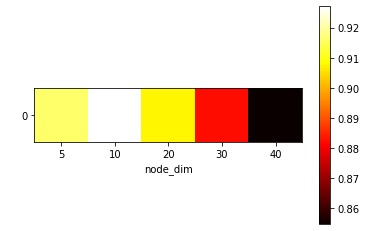

In [37]:
a = np.array([[node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] for node_dim in [5, 10, 20, 30, 40]]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2, 3, 4], labels=[5, 10, 20, 30, 40])
plt.xlabel("node_dim")
plt.yticks(ticks=[0], labels=[0])
plt.ylabel(" ")

Example of using Heatmap to viualize the result.

In [20]:
deepwalk_auc_scores

{(10, 10, 10): 0.9274812167386944}

In [18]:
plt.figure(figsize=(6, 4))
node_dim = 20
# you should have an auc score dictionary here.
a = np.array([[deepwalk_auc_scores[(node_dim, num_walks, walk_length)] for walk_length in [10, 20, 40]] for num_walks in [5, 10, 20, 40]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels=[10, 20, 40])
plt.xlabel("walk_length")
plt.yticks(ticks=[0,1,2,3], labels=[5, 10, 20, 40])
plt.ylabel("num_walks")

KeyError: ignored

<Figure size 432x288 with 0 Axes>

You can build model with the best parameters you find and save the prediction here.

In [ ]:
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10)
scores = [get_cosine_sim(model, src, dst) for src, dst in test_edges]
write_pred("data/pred.csv", test_edges, scores)

building a DeepWalk model...	number of walks: 83280	average walk length: 9.8980	trainig time: 37.0635


With the help of p and q, the node2vec model can fit training data better. And you can have a try if you set p=q=1, the two models will return the same results.